In [29]:
using LinearAlgebra

using Plots
default(fmt = :png)

using DifferentialEquations
using Flux
using DiffEqFlux

In [30]:
const N = 64
const L = 2
const Δx = L / N
const κ = 1

x = range(-L/2, L/2, length=N)

datasize = 30
tspan = (0.0, 0.2)
t = range(tspan[1], tspan[2], length=datasize)

0.0:0.006896551724137931:0.2

In [31]:
 d = -2 * ones(N)
sd = ones(N-1)
A = Array(Tridiagonal(sd, d, sd))
A[1, N] = 1
A[N, 1] = 1
A_diffusion = (κ/Δx^2) .* A

function diffusion(∂u∂t, u, p, t)
    ∂u∂t .= A_diffusion * u
    return
end

diffusion (generic function with 1 method)

In [32]:
u₀s = [
    x -> 0.5,
    # x -> exp(-50x^2),
    x -> exp(-20x^2),
    x -> -cos(π*x + π/4),
    # x -> cos(2π*x),
    # x -> sin(π*x),
    # x -> sin(2π*x)
]

3-element Array{Function,1}:
 getfield(Main, Symbol("##47#50"))()
 getfield(Main, Symbol("##48#51"))()
 getfield(Main, Symbol("##49#52"))()

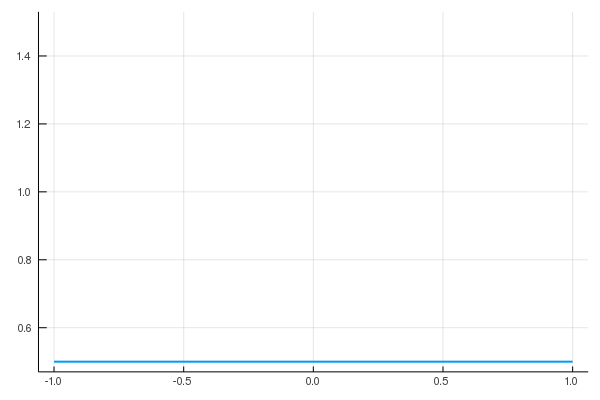

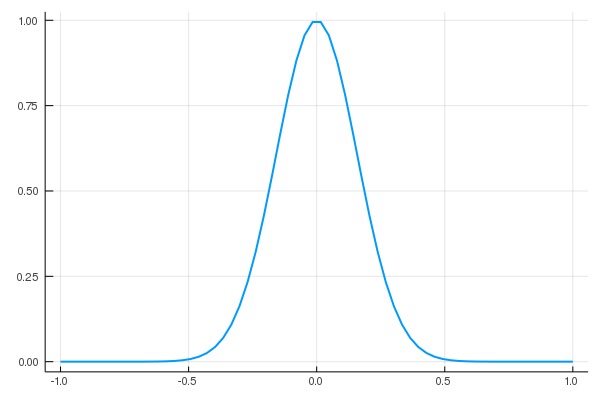

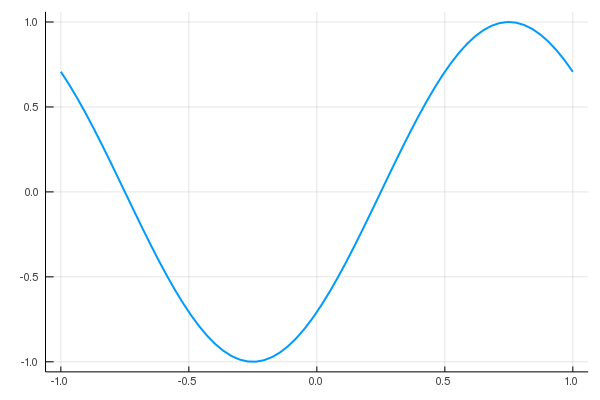

In [33]:
for u₀ in u₀s
    display(plot(x, u₀.(x), linewidth=2, label=""))
end

In [34]:
pde_data = []
for (i, u₀) in enumerate(u₀s)
    println("Generating PDE data with initial condition $i...")
    
    u₀_ic = @. u₀(x)
    prob = ODEProblem(diffusion, u₀_ic, tspan)
    solution = Array(solve(prob, Tsit5(), saveat=t))
    
    push!(pde_data, solution)
end

Generating PDE data with initial condition 1...
Generating PDE data with initial condition 2...
Generating PDE data with initial condition 3...


In [35]:
dudt_NN = Chain(Dense(N, N, tanh),
                Dense(N, N))

ps = Flux.params(dudt_NN)

neural_pde_prediction = u₀ -> neural_ode(dudt_NN, u₀, tspan, Tsit5(), saveat=t, reltol=1e-7, abstol=1e-9)

#53 (generic function with 1 method)

In [36]:
data = Iterators.repeated((), 1000)
opt = ADAM(0.1)

ADAM(0.1, (0.9, 0.999), IdDict{Any,Any}())

In [37]:
M = length(u₀s)
loss_function() = sum(sum(abs2, pde_data[i] .- neural_pde_prediction(u₀s[i].(x))) for i in 1:M)

loss_function (generic function with 1 method)

In [38]:
# Callback function to observe training.
cb = function ()
    loss = loss_function()
    println("loss = $loss")
    loss < 10 && Flux.stop()
end

#57 (generic function with 1 method)

In [39]:
Flux.train!(loss_function, ps, data, opt, cb = cb)

loss = 546.1141310031232 (tracked)
loss = 117.20763720603637 (tracked)
loss = 91.08945201087968 (tracked)
loss = 102.70286767637629 (tracked)
loss = 112.3465660516094 (tracked)
loss = 134.5087958420725 (tracked)
loss = 161.9768655131786 (tracked)
loss = 166.23299209736666 (tracked)
loss = 155.62917130962052 (tracked)
loss = 143.66579177592118 (tracked)
loss = 142.5708384270005 (tracked)
loss = 147.13014069407166 (tracked)
loss = 147.40861977835624 (tracked)
loss = 150.6599647940615 (tracked)
loss = 156.2709637119647 (tracked)
loss = 164.73508136940404 (tracked)
loss = 175.5187094283161 (tracked)
loss = 191.56337084082617 (tracked)
loss = 197.9682047862479 (tracked)
loss = 195.06383982556525 (tracked)
loss = 197.19282686483064 (tracked)
loss = 192.5989432140016 (tracked)
loss = 184.73413206750644 (tracked)
loss = 181.8455907828465 (tracked)
loss = 177.28036618674687 (tracked)
loss = 172.37367001959836 (tracked)
loss = 169.75995774282984 (tracked)
loss = 170.0585788650145 (tracked)
loss 

┌ Warning: dt <= dtmin. Aborting. There is either an error in your model specification or the true solution is unstable.
└ @ DiffEqBase /home/gridsan/aramadhan/.julia/packages/DiffEqBase/4V8I6/src/integrator_interface.jl:162


loss = 1570.7706555087905 (tracked)
loss = 2607.058162545576 (tracked)
loss = 2795.896548583347 (tracked)
loss = 3488.589096971349 (tracked)
loss = 3757.778117365741 (tracked)
loss = 4036.894733633774 (tracked)
loss = 4362.218611828466 (tracked)
loss = 4361.095717647328 (tracked)
loss = 4329.563633446192 (tracked)
loss = 4255.542128541595 (tracked)
loss = 4052.755835525363 (tracked)
loss = 3453.885222406319 (tracked)
loss = 2875.6300322903994 (tracked)
loss = 2974.829070679746 (tracked)
loss = 3061.2711106846536 (tracked)
loss = 3131.419520995778 (tracked)
loss = 3072.110095928995 (tracked)
loss = 3065.719795970646 (tracked)
loss = 3077.0928843154925 (tracked)
loss = 3072.7293496020843 (tracked)
loss = 3046.058235373937 (tracked)
loss = 3032.129007159213 (tracked)
loss = 3030.448105882846 (tracked)
loss = 3027.56089183957 (tracked)
loss = 3120.950525543394 (tracked)
loss = 3174.796072964714 (tracked)
loss = 3187.548937258806 (tracked)
loss = 3049.5262544272878 (tracked)
loss = 3114.530

In [40]:
for (i, (u₀, pde_data_i)) in enumerate(zip(u₀s, pde_data))
    u₀_ic = @. u₀(x)
    nn_pred = Flux.data(neural_pde_prediction(u₀_ic))
    
    println("Creating .gif for data from initial condition $i...")
    anim = @gif for n=1:datasize
        plot(x, pde_data_i[:, n], linewidth=2, ylim=(-1, 1), label="data", show=false)
        plot!(x, nn_pred[:, n],   linewidth=2, ylim=(-1, 1), label="Neural PDE", show=false)
    end
    
    display(anim)
end

Creating .gif for data from initial condition 1...


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Creating .gif for data from initial condition 2...


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Creating .gif for data from initial condition 3...


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


In [41]:
u₀s_test = [
    x -> 0.8,
    x -> exp(-50*abs(x)),
    x -> cos(π*x + π/2),
    x -> sin(π*x - π/2)
]

4-element Array{Function,1}:
 getfield(Main, Symbol("##59#63"))()
 getfield(Main, Symbol("##60#64"))()
 getfield(Main, Symbol("##61#65"))()
 getfield(Main, Symbol("##62#66"))()

In [42]:
for (i, u₀) in enumerate(u₀s_test)
    u₀_ic = (@. u₀(x))
    
        prob = ODEProblem(diffusion, u₀_ic, tspan)
    solution = solve(prob, Tsit5(), saveat=t)
    
    nn_pred = Flux.data(neural_pde_prediction(u₀_ic))
    
    println("Creating .gif for data from initial condition $i...")
    anim = @gif for n=1:datasize
        plot(x, solution[:, n], linewidth=2, ylim=(-1, 1), label="data", show=false)
        plot!(x, nn_pred[:, n], linewidth=2, ylim=(-1, 1), label="Neural ODE", show=false)
    end
    
    display(anim)
end

Creating .gif for data from initial condition 1...


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Creating .gif for data from initial condition 2...


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Creating .gif for data from initial condition 3...


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95


Creating .gif for data from initial condition 4...


Plots.AnimatedGif("/home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif")

┌ Info: Saved animation to 
│   fn = /home/gridsan/aramadhan/6S898-climate-parameterization/notebooks/tmp.gif
└ @ Plots /home/gridsan/aramadhan/.julia/packages/Plots/Iuc9S/src/animation.jl:95
